In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso,Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error

In [4]:
insurance_data = pd.read_csv("insurance.csv")

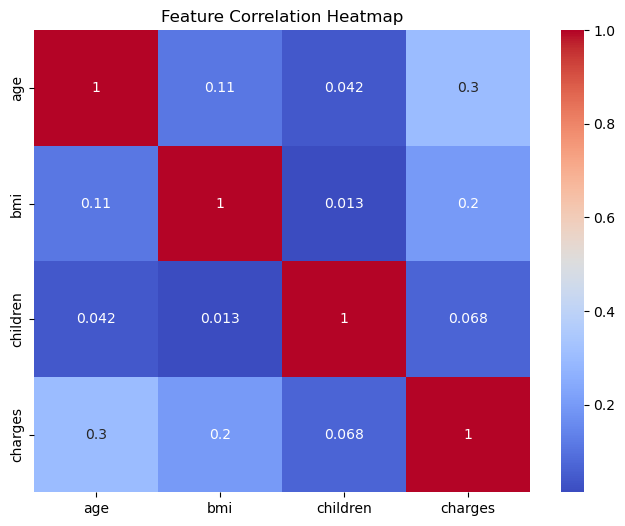

In [5]:
#Generate a correlation heatmap to see how features like 'age' or 'bmi' relate to 'charges'
plt.figure(figsize=(8,6))
sns.heatmap(insurance_data.select_dtypes(include="number").corr(),
            annot=True,
            cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
# Separate features (X) and target variable (y)
X = insurance_data.drop("charges", axis=1)
y = insurance_data["charges"]

# One-hot encode the 'region' column and drop the first to avoid the dummy variable trap
X = pd.get_dummies(X, columns=["region"], drop_first=True, dtype=int)

# Convert categorical binary strings into numeric 0s and 1s
X["sex"] = X["sex"].map({"female": 1, "male": 0})
X["smoker"] = X["smoker"].map({"yes": 1, "no": 0})

# Create interaction terms to capture combined effects of age/bmi with smoking status
X["age_smoker"] = X["age"] + X["smoker"]
X["bmi_smoker"] = X["bmi"] + X["smoker"]

# Split data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [7]:
# Setup a pipeline to scale data (StandardScaler) then apply Lasso Regression
pipe_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(max_iter=20000, random_state=42, tol=0.1))
])

# Define the range of 'alpha' (regularization strength) to test
params_lasso = {
    "lasso__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}

# Use Cross-Validation to find the best alpha value
grid_lasso = GridSearchCV(pipe_lasso, params_lasso, cv=5)
grid_lasso.fit(X_train, y_train)

# Predict and evaluate performance
y_pred = grid_lasso.predict(X_test)
print("Best alpha:", grid_lasso.best_params_)

Best alpha: {'lasso__alpha': 100}


In [8]:
# Calculate evaluation metrics for the Lasso model
# MSE measures the average squared difference between actual and predicted values
mse = mean_squared_error(y_test, y_pred)

# RMSE is the square root of MSE, providing error in the same units as the target (charges)
rmse = np.sqrt(mse)

# R2 Score (Coefficient of Determination) represents the proportion of variance explained by the model
r2 = r2_score(y_test, y_pred)

# Display the performance results
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)


MSE: 33867535.58616716
RMSE: 5819.5820800266365
R2 Score: 0.7690182748509743


In [9]:
# Setup a similar pipeline for Ridge Regression
pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

# Define alpha hyperparameters for Ridge
params_ridge = {
    "ridge__alpha": [0.01, 0.1, 1, 10, 100]
}

# Tune the Ridge model using GridSearch
grid_ridge = GridSearchCV(pipe_ridge, params_ridge, cv=5)
grid_ridge.fit(X_train, y_train)

# Predict using the optimized Ridge model
y_pred_ridge = grid_ridge.predict(X_test)

# Calculate Accuracy Metrics: MSE (Error), RMSE (Avg deviation), and R2 (Variance explained)
r2 = r2_score(y_test, y_pred_ridge)
print("Best alpha:", grid_ridge.best_params_)

Best alpha: {'ridge__alpha': 10}


In [10]:
# Repeat error calculations for Ridge comparison
mse = mean_squared_error(y_test, y_pred_ridge)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_ridge)

print("Ridge MSE:", mse)
print("Ridge RMSE:", rmse)
print("Ridge R2:", r2)

Ridge MSE: 33837122.1038314
Ridge RMSE: 5816.968463369163
Ridge R2: 0.7692256994095115


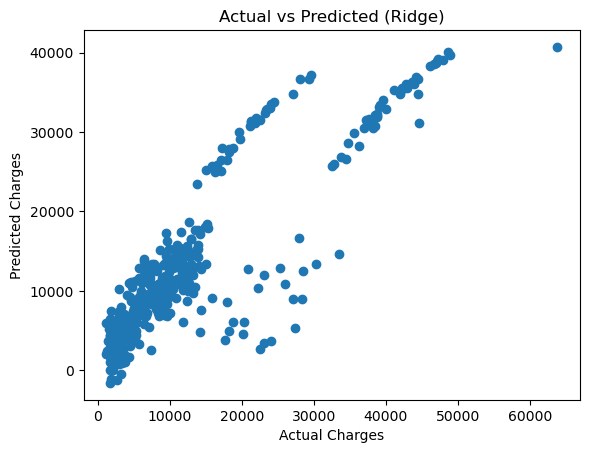

In [11]:
# Visualize the relationship between actual costs and the model's predictions
plt.scatter(y_test, y_pred_ridge)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted (Ridge)")
plt.show()
